# Participant Screening: Illusory Tempo - Forced Directional Response II

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

OUTFILE = '../data/excluded.txt'

plt.rc('figure', titlesize=32)  # fontsize of the figure title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Load data

In [2]:
datafiles = glob('../data/Il*.csv')
all_data = pd.concat((pd.read_csv(f) for f in datafiles))
scores = pd.read_csv('../data/scores.csv')

# Headphone test exclusion

Exclude participants who failed to answer at least 4 out of 6 headphone test questions correctly on both attempts.

FAILED: 17
[  6   7  12  21  22  29  33  38  47  56  58  64  65 101 105 106 127]


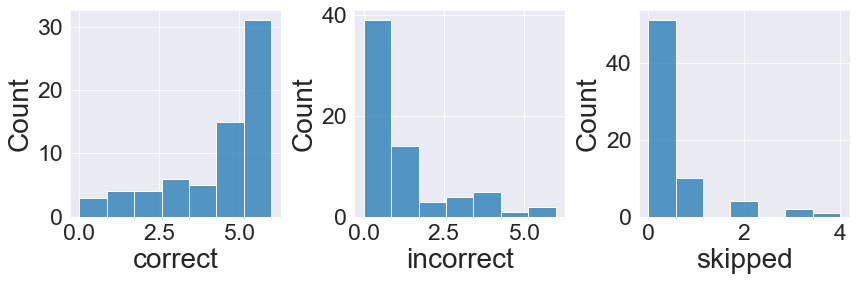

In [3]:
# Select audio test data
testpres = all_data.loc[all_data.event == 'headphone_test_tones', :].reset_index()
testresp = all_data.loc[all_data.event == 'headphone_test_response', :].reset_index()
testresp = testresp.assign(response=np.array(testresp.key_press, dtype=int) - 48,
                          answer=[s.find('S') - 28 for s in testpres.stimulus])
testresp = testresp.assign(correct=testresp.response == testresp.answer,
                          incorrect=(testresp.response != testresp.answer) & (testresp.response > 0),
                          skipped=testresp.response == 0)

# Audio test performance
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(testresp.groupby('subject').correct.sum(), bins=7)
plt.subplot(132)
sns.histplot(testresp.groupby('subject').incorrect.sum(), bins=7)
plt.subplot(133)
sns.histplot(testresp.groupby('subject').skipped.sum(), bins=7)
plt.tight_layout()

# Exclude participants if they got fewer than 4 trials correct
grouped = testresp.groupby('subject')
failed_test = grouped.correct.sum() < 4
failed_test = np.array(failed_test[failed_test].reset_index().subject)
print('FAILED: %i' % (len(failed_test)))
print(failed_test)

EXCLUDED: 6
[ 29  38  58  64 105 127]


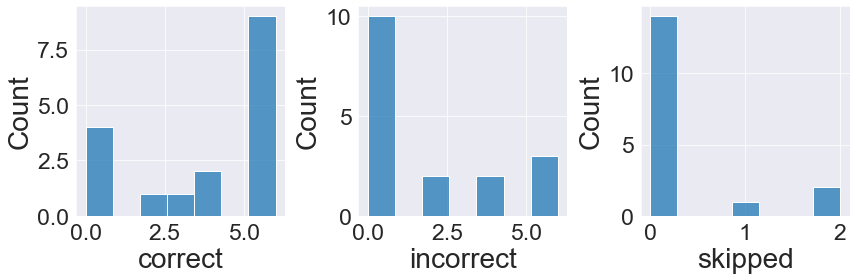

In [4]:
# Select anyone who failed the first test to see if they also failed the second test
if len(failed_test) > 0:
    failed = all_data[np.isin(all_data.subject, failed_test)]

    # Select audio retest data
    testpres = failed.loc[failed.event == 'headphone_retest_tones', :].reset_index()
    testresp = failed.loc[failed.event == 'headphone_retest_response', :].reset_index()
    testresp = testresp.assign(response=np.array(testresp.key_press, dtype=int) - 48,
                              answer=[s.find('S') - 28 for s in testpres.stimulus])
    testresp = testresp.assign(correct=testresp.response == testresp.answer,
                              incorrect=(testresp.response != testresp.answer) & (testresp.response > 0),
                              skipped=testresp.response == 0)

    # Audio test performance
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    sns.histplot(testresp.groupby('subject').correct.sum(), bins=7)
    plt.subplot(132)
    sns.histplot(testresp.groupby('subject').incorrect.sum(), bins=7)
    plt.subplot(133)
    sns.histplot(testresp.groupby('subject').skipped.sum(), bins=7)
    plt.tight_layout()

    # Exclude participants if they got fewer than 4 trials correct
    grouped = testresp.groupby('subject')
    failed_test = grouped.correct.sum() < 4
    failed_test = np.array(failed_test[failed_test].reset_index().subject)
    print('EXCLUDED: %i' % (len(failed_test)))
    print(failed_test)

    # Drop excluded subjects before proceeding
    data = all_data[~np.isin(all_data.subject, failed_test)]
    
else:
    data = all_data

# Negative d' exclusion

In [5]:
grouped = scores.groupby('subject')
neg_dp = grouped.subj_dprime.mean() < 0
neg_dp = np.array(neg_dp[neg_dp].reset_index().subject)
print('EXCLUDED: %i' % (len(neg_dp)))
print(neg_dp)
data = data[~np.isin(data.subject, neg_dp)]

EXCLUDED: 7
[ 12  13  21  26  35 103 122]


# Save Exclusion

In [6]:
included = data.subject.unique()
conditions = np.array([x[0] for x in all_data.groupby('subject').type.unique()])
incl_conditions = np.array([x[0] for x in data.groupby('subject').type.unique()])
excluded = np.union1d(failed_test, neg_dp)
np.savetxt(OUTFILE, excluded, fmt='%i')

print('EXCLUSION LIST:', excluded)
print('INCLUSION LIST:', included.tolist())
print('TOTALS:', len(excluded) + len(included), len(included))
print('CONDITIONS:', np.sum(conditions == 0), np.sum(conditions == 1), np.sum(incl_conditions == 0), np.sum(incl_conditions == 1))

EXCLUSION LIST: [ 12  13  21  26  29  35  38  58  64 103 105 122 127]
INCLUSION LIST: [2, 3, 4, 5, 6, 7, 9, 10, 11, 16, 15, 17, 18, 19, 20, 22, 23, 24, 25, 27, 30, 32, 33, 34, 36, 37, 41, 43, 56, 61, 60, 63, 65, 47, 100, 98, 101, 102, 104, 107, 109, 112, 106, 115, 117, 116, 118, 119, 121, 124, 125, 126, 128, 129, 130]
TOTALS: 68 55
CONDITIONS: 36 32 30 25
